In [1]:
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select your products.csv

Saving AAPL_stock_features.csv to AAPL_stock_features.csv


In [2]:
import pandas as pd
import io

# Read the uploaded file
df = pd.read_csv(io.BytesIO(uploaded['AAPL_stock_features.csv']))
print(df)

# Or if you just want to save it first:
with open('AAPL_stock_features.csv', 'wb') as f:
    f.write(uploaded['AAPL_stock_features.csv'])

df = pd.read_csv('AAPL_stock_features.csv')
print(df)

           Date       Close        High         Low        Open       Volume  \
0    2020-10-15  117.704201  118.181997  115.207950  115.763756  112559200.0   
1    2020-10-16  116.056244  118.523250  115.851474  118.259969  115393800.0   
2    2020-10-19  113.091957  117.421391  112.779926  116.972846  120639300.0   
3    2020-10-20  114.583862  116.017259  112.750672  113.306478  124423700.0   
4    2020-10-21  113.959801  115.753979  113.550254  113.764776   89946000.0   
..          ...         ...         ...         ...         ...          ...   
802  2023-12-22  192.444595  194.243791  191.818350  194.015153   37122800.0   
803  2023-12-26  191.897873  192.732856  191.679185  192.454528   28919300.0   
804  2023-12-27  191.997269  192.345186  189.949565  191.341219   48087700.0   
805  2023-12-28  192.424698  193.498254  192.017141  192.981353   34049900.0   
806  2023-12-29  191.380966  193.239801  190.585738  192.742785   42628800.0   

           MA10        MA50       MA100

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load the enhanced dataset
def load_enhanced_data(ticker="AAPL"):
    df = pd.read_csv(f"{ticker}_stock_features.csv")
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is datetime
    df.set_index('Date', inplace=True)
    return df

ticker = "AAPL"
data = load_enhanced_data(ticker)
print(data.head())  # Verify all features are loaded

                 Close        High         Low        Open       Volume  \
Date                                                                      
2020-10-15  117.704201  118.181997  115.207950  115.763756  112559200.0   
2020-10-16  116.056244  118.523250  115.851474  118.259969  115393800.0   
2020-10-19  113.091957  117.421391  112.779926  116.972846  120639300.0   
2020-10-20  114.583862  116.017259  112.750672  113.306478  124423700.0   
2020-10-21  113.959801  115.753979  113.550254  113.764776   89946000.0   

                  MA10        MA50       MA100      MA200        RSI  \
Date                                                                   
2020-10-15  114.778878  114.007473  101.501438  86.176186  63.102333   
2020-10-16  115.363935  114.111272  101.887925  86.392887  56.510599   
2020-10-19  115.313230  114.206198  102.244428  86.598301  52.833579   
2020-10-20  115.737399  114.299466  102.616604  86.808306  52.563354   
2020-10-21  115.911942  114.445634  102.97

In [5]:
# Select features and target
features = ['Close', 'MA100', 'RSI', 'Norm_Volume', 'Bollinger_Upper', 'Bollinger_Lower']
data = data[features]  # Keep only selected features

In [6]:
def min_max_scaling(data):
    """Scale data to [0, 1] range and return scaled data + min/max values"""
    min_val = np.min(data)
    max_val = np.max(data)
    # Handle case where all values are identical (avoid division by zero)
    if max_val == min_val:
        return np.zeros_like(data), min_val, max_val
    return (data - min_val) / (max_val - min_val), min_val, max_val

In [7]:
def scale_features(df):
    """Scale each feature column independently"""
    scaled_data = {}
    scalers = {}  # To store min/max for each feature

    for col in df.columns:
        if col == 'Close':  # Our target
            scaled_values, min_val, max_val = min_max_scaling(df[col].values)
            scalers['target'] = (min_val, max_val)
        else:
            scaled_values, min_val, max_val = min_max_scaling(df[col].values)
            scalers[col] = (min_val, max_val)

        scaled_data[col] = scaled_values

    return pd.DataFrame(scaled_data), scalers

# Scale all features
scaled_data, scalers = scale_features(data)

# Split into train/test (keeping temporal order)
split_ratio = 0.8
split_index = int(len(scaled_data) * split_ratio)
train_data = scaled_data.iloc[:split_index]
test_data = scaled_data.iloc[split_index:]

In [8]:
def create_sequences_multi(data, seq_length=50, target_col='Close'):
    """Create sequences from multiple features"""
    X, y = [], []
    data_values = data.values  # Convert to numpy array

    for i in range(len(data) - seq_length):
        # All features for the sequence
        X.append(data_values[i:i+seq_length, :])
        # Only the Close price as target
        y.append(data_values[i+seq_length, data.columns.get_loc(target_col)])

    return np.array(X), np.array(y)

# Create sequences
seq_length = 50
X_train, y_train = create_sequences_multi(train_data, seq_length)
X_test, y_test = create_sequences_multi(test_data, seq_length)

# Note: No need to reshape since we already have 3D (samples, timesteps, features)
print(f"Training shapes - X: {X_train.shape}, y: {y_train.shape}")
print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

Training shapes - X: (595, 50, 6), y: (595,)
Test shapes - X: (112, 50, 6), y: (112,)


In [20]:
class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = learning_rate

        # Weights for forget gate
        self.Wf = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bf = np.zeros((hidden_dim, 1))

        # Weights for input gate
        self.Wi = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bi = np.zeros((hidden_dim, 1))

        # Weights for candidate memory cell
        self.Wc = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bc = np.zeros((hidden_dim, 1))

        # Weights for output gate
        self.Wo = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bo = np.zeros((hidden_dim, 1))

        # Output layer
        self.Wy = np.random.randn(output_dim, hidden_dim) * 0.01
        self.by = np.zeros((output_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, x):
        return 1 - x ** 2

    def forward(self, x_seq, h=None, c=None):
        if h is None:
            h = np.zeros((self.hidden_dim, 1))
        if c is None:
            c = np.zeros((self.hidden_dim, 1))

        self.caches = []

        for x in x_seq:
            x = x.reshape(self.input_dim, 1)
            concat = np.vstack((h, x))

            ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
            it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
            c_tilde = self.tanh(np.dot(self.Wc, concat) + self.bc)
            c = ft * c + it * c_tilde
            ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
            h = ot * self.tanh(c)

            self.caches.append((h, c, ft, it, c_tilde, ot, concat))

        y_hat = np.dot(self.Wy, h) + self.by

        return y_hat, h, c


    def backward(self, x_seq, y_hat, y_true):
        dh_next = np.zeros((self.hidden_dim, 1))
        dc_next = np.zeros((self.hidden_dim, 1))

        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWc = np.zeros_like(self.Wc)
        dWo = np.zeros_like(self.Wo)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbc = np.zeros_like(self.bc)
        dbo = np.zeros_like(self.bo)

        dy = y_hat - y_true  # MSE derivative
        dWy = np.dot(dy, self.caches[-1][0].T)
        dby = dy

        dh = np.dot(self.Wy.T, dy) + dh_next
        for t in reversed(range(len(x_seq))):
            h, c, ft, it, c_tilde, ot, concat = self.caches[t]
            c_prev = self.caches[t - 1][1] if t > 0 else np.zeros_like(c)

            do = dh * self.tanh(c)
            do_raw = do * self.dsigmoid(ot)

            dc = dh * ot * self.dtanh(self.tanh(c)) + dc_next
            dc_tilde = dc * it
            dc_tilde_raw = dc_tilde * self.dtanh(c_tilde)

            di = dc * c_tilde
            di_raw = di * self.dsigmoid(it)

            df = dc * c_prev
            df_raw = df * self.dsigmoid(ft)

            dWf += np.dot(df_raw, concat.T)
            dWi += np.dot(di_raw, concat.T)
            dWc += np.dot(dc_tilde_raw, concat.T)
            dWo += np.dot(do_raw, concat.T)

            dbf += df_raw
            dbi += di_raw
            dbc += dc_tilde_raw
            dbo += do_raw

            dconcat = (np.dot(self.Wf.T, df_raw)
                       + np.dot(self.Wi.T, di_raw)
                       + np.dot(self.Wc.T, dc_tilde_raw)
                       + np.dot(self.Wo.T, do_raw))

            dh = dconcat[:self.hidden_dim, :]
            dc_next = dc * ft

        # Update all weights and biases
        self.Wf -= self.lr * dWf
        self.Wi -= self.lr * dWi
        self.Wc -= self.lr * dWc
        self.Wo -= self.lr * dWo
        self.bf -= self.lr * dbf
        self.bi -= self.lr * dbi
        self.bc -= self.lr * dbc
        self.bo -= self.lr * dbo
        self.Wy -= self.lr * dWy
        self.by -= self.lr * dby

    def train(self, X_train, y_train, epochs=10, batch_size=32):
        num_samples = len(X_train)
        for epoch in range(epochs):
            total_loss = 0
            # Shuffle indices for batching
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_indices = indices[start_idx:end_idx]

                # Batch gradients
                for i in batch_indices:
                    x_seq = X_train[i]
                    y_true = y_train[i].reshape(self.output_dim, 1)

                    y_hat, _, _ = self.forward(x_seq)
                    loss = np.mean((y_hat - y_true) ** 2)
                    total_loss += loss
                    self.backward(x_seq, y_hat, y_true)

            avg_loss = total_loss / num_samples
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")


In [21]:
num_features = len(features)
lstm = LSTM(input_dim=num_features, hidden_dim=128, output_dim=1, learning_rate=0.01)#, dropout_rate=0.2)
lstm.train(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50, Loss: 0.042924
Epoch 2/50, Loss: 0.027255
Epoch 3/50, Loss: 0.026879
Epoch 4/50, Loss: 0.026616
Epoch 5/50, Loss: 0.026174
Epoch 6/50, Loss: 0.025594
Epoch 7/50, Loss: 0.024855
Epoch 8/50, Loss: 0.024017
Epoch 9/50, Loss: 0.022813
Epoch 10/50, Loss: 0.021512
Epoch 11/50, Loss: 0.019893
Epoch 12/50, Loss: 0.018112
Epoch 13/50, Loss: 0.016183
Epoch 14/50, Loss: 0.014238
Epoch 15/50, Loss: 0.012202
Epoch 16/50, Loss: 0.010340
Epoch 17/50, Loss: 0.008642
Epoch 18/50, Loss: 0.007193
Epoch 19/50, Loss: 0.005999
Epoch 20/50, Loss: 0.005097
Epoch 21/50, Loss: 0.004389
Epoch 22/50, Loss: 0.003863
Epoch 23/50, Loss: 0.003473
Epoch 24/50, Loss: 0.003174
Epoch 25/50, Loss: 0.002919
Epoch 26/50, Loss: 0.002763
Epoch 27/50, Loss: 0.002601
Epoch 28/50, Loss: 0.002484
Epoch 29/50, Loss: 0.002398
Epoch 30/50, Loss: 0.002315
Epoch 31/50, Loss: 0.002225
Epoch 32/50, Loss: 0.002155
Epoch 33/50, Loss: 0.002112
Epoch 34/50, Loss: 0.002056
Epoch 35/50, Loss: 0.002012
Epoch 36/50, Loss: 0.001965
E

In [22]:
def predict_multi(lstm, X_test, scalers):
    predictions = []

    for i in range(len(X_test)):
        x_seq = X_test[i]
        # Reinitialize h and c for stateless predictions
        h_prev = np.zeros((lstm.hidden_dim, 1))
        c_prev = np.zeros((lstm.hidden_dim, 1))
        y_pred, _, _ = lstm.forward(x_seq, h_prev, c_prev)
        predictions.append(y_pred.flatten()[0])

    # Inverse scale predictions
    min_target, max_target = scalers['target']
    predictions = np.array(predictions) * (max_target - min_target) + min_target
    return predictions


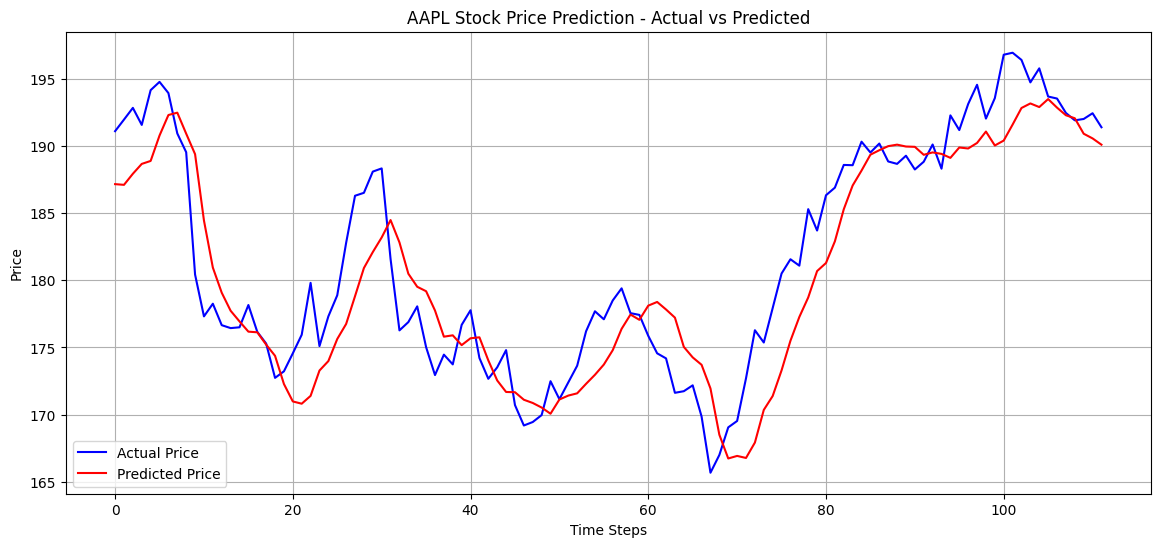

In [23]:
# Inverse transform y_test
min_target, max_target = scalers['target']
y_test_actual = y_test * (max_target - min_target) + min_target

# Generate predictions
predictions = predict_multi(lstm, X_test, scalers)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title(f"{ticker} Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Align the dates with predictions (considering sequence length offset)
test_dates = data.index[split_index + seq_length:]  # since we lose 'seq_length' rows when creating sequences

# Create a DataFrame with Date, Actual Price, and Predicted Price
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual,
    'Predicted Price': predictions
})

# Optional: round for cleaner view
results_df['Actual Price'] = results_df['Actual Price'].round(2)
results_df['Predicted Price'] = results_df['Predicted Price'].round(2)

# Display the table
print(results_df.head(10))  # Show first 10 rows


        Date  Actual Price  Predicted Price
0 2023-07-24        191.09           187.15
1 2023-07-25        191.95           187.10
2 2023-07-26        192.82           187.92
3 2023-07-27        191.56           188.65
4 2023-07-28        194.14           188.88
5 2023-07-31        194.76           190.77
6 2023-08-01        193.92           192.29
7 2023-08-02        190.92           192.47
8 2023-08-03        189.52           190.90
9 2023-08-04        180.42           189.38
